In [32]:
import os, random, json, pickle, itertools
import torch
from torchvision.transforms import transforms
from torch.utils.data  import Dataset
import cv2
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [3]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [5]:
# string representation of ImageNet1k class labels
with open(os.path.join('data', 'imagenet-class-labels.json'), "r") as json_file:
    class_idx = json.load(json_file)
idx2label = [class_idx[str(k)] for k in range(len(class_idx))]

# class label mapping from imagefolder to class label in ImageNet1k
class_path_to_label = {
    "n01440764": "0",
    "n02102040": "217",
    "n02979186": "482",
    "n03000684": "491",
    "n03028079": "497",
    "n03394916": "566", 
    "n03417042": "569",
    "n03425413": "571",
    "n03445777": "574",
    "n03888257": "701"
}

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),         
    transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.shape[0] == 1 else x),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
# custom Dataset class to load Imagenette Dataset
class ImagenetteDataset(Dataset):
    def __init__(self, transform, class_path_to_label, subset_size=None):
        self.root_path = os.path.join('data', 'imagenette2')
        class_paths = os.listdir(os.path.join(self.root_path, 'train'))
        self.data = []
        for class_path in class_paths[:8]:
            # these are the standard training images of ImageNet1k
            for split in ['train', 'val']:
                for img_path in os.listdir(os.path.join(self.root_path, split, class_path)):
                    self.data.append([os.path.join(self.root_path, split, class_path, img_path), class_path])
        self.transform = transform 
        self.class_path_to_label = class_path_to_label

        # option to only work on a subset
        if subset_size is not None and subset_size < len(self.data):
            self.data = random.sample(self.data, subset_size)

    def __len__(self):
        return len(self.data)    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        class_id = torch.tensor(int(self.class_path_to_label[class_name]))
        
        return img_tensor, class_id

In [7]:
dataset = ImagenetteDataset(transform, class_path_to_label)

In [8]:
sample_idx = 2406

img_path, cls_path = dataset.data[sample_idx]
img_array = cv2.resize(cv2.imread(img_path), (224,224))
img_tensor = transform(Image.open(img_path))
class_id = int(class_path_to_label[cls_path])

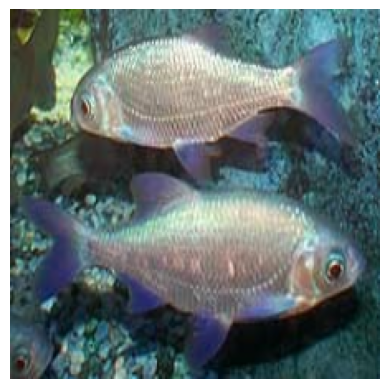

In [36]:
fig = plt.figure(frameon=False)
plt.imshow(img_array)
plt.axis('off')
name=f'cls_{class_id}_idx_{sample_idx}_IntegratedGradients_image.jpg'
fig.savefig(os.path.join(os.path.abspath(''), 'data', 'postprocessing_sample', name), bbox_inches='tight', pad_inches=0, dpi=300, transparent=True)

In [11]:
with open('attr_maps_imagenette_morph.pickle', 'rb') as f:
    attr_maps = pickle.load(f)

In [12]:
methods = ['LIME', 'KernelSHAP', 'IntegratedGradients', 'GradientSHAP', 'AttentionRollout', 'BeyondAttention']

In [13]:
def calculate_iou(masks1, masks2):
    intersection = np.logical_and(masks1, masks2)
    union = np.logical_or(masks1, masks2)
    denominator = np.sum(union, axis=(1,2)) # avoid division by 0
    iou_score = np.sum(intersection, axis=(1,2)) / np.where(denominator == 0, 1, denominator)
    return np.mean(iou_score, axis=0)
def calculate_dice_coefficient(masks1, masks2):
    intersection = np.logical_and(masks1, masks2)
    denominator = np.sum(masks1, axis=(1,2)) + np.sum(masks2, axis=(1,2)) # avoid division by 0
    dice_coefficient = (2 * np.sum(intersection, axis=(1,2))) / np.where(denominator == 0, 1, denominator)
    return np.mean(dice_coefficient, axis=0)
def calculate_coverage_ratio(masks1, masks2):
    intersection = np.logical_and(masks1, masks2)
    denominator = np.sum(masks1, axis=(1,2))
    coverage_ratio = np.sum(intersection, axis=(1,2)) / np.where(denominator == 0, 1, denominator)
    return np.mean(coverage_ratio, axis=0)

dict_metrics = {
    "IoU": {},
    "CoverageRatio": {},
}     

# iterate through all possible combination of explainability method and calculate the metrics
for pair in itertools.permutations(methods, r=2):
    dict_metrics["IoU"][(pair[0], pair[1])] = calculate_iou(attr_maps[pair[0]], attr_maps[pair[1]])
    dict_metrics["CoverageRatio"][(pair[0], pair[1])] = calculate_coverage_ratio(attr_maps[pair[0]], attr_maps[pair[1]])

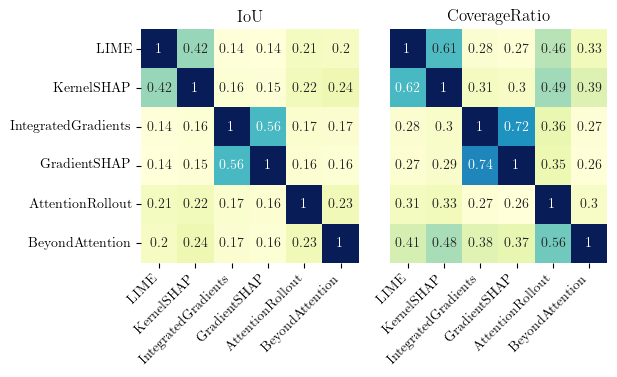

In [85]:
fig, axes = plt.subplots(2, (len(dict_metrics)+1), figsize=((len(dict_metrics)+1) * 20, 20), gridspec_kw={'width_ratios': [0.12, 1, 1], 'height_ratios': [1, 0.2]})

# Iterate over each metric in the dict_metrics
for idx, (metric_name, metric_data) in enumerate(dict_metrics.items()):
    # Convert the metric_data dictionary to a matrix
    matrix = [
        [
            metric_data.get(
                (method1, method2), 
                metric_data.get((method2, method1), 1.0)
            ) for method2 in methods
        ]
        for method1 in methods
    ]

    # Create heatmap using seaborn
    sns.heatmap(matrix, annot=True, cmap='YlGnBu', cbar=False, ax=axes[0][idx+1])
    if idx == 0:
        axes[0][idx+1].set_yticklabels(methods, rotation=0)
    else:
        axes[0][idx+1].set_yticks([])
    axes[0][idx+1].set_xticklabels(methods, rotation=45, ha='right')
    axes[0][idx+1].set_title(metric_name)

axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['bottom'].set_visible(False)
axes[0][0].spines['left'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])

for i in range(len(dict_metrics)+1):
    axes[1][i].spines['top'].set_visible(False)
    axes[1][i].spines['bottom'].set_visible(False)
    axes[1][i].spines['left'].set_visible(False)
    axes[1][i].spines['right'].set_visible(False)
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])
    axes[1][i].set_facecolor('none')
fig.set_size_inches(w=6.75, h=4)
fig.savefig('histogram.pgf')